In [1]:
import numpy as np
import pandas as pd

In [2]:
api_df = pd.read_csv('/opt/ml/level-3-final-project/Model/data/problem_api_1000_to_25150.csv')
meta_df = pd.read_csv('/opt/ml/level-3-final-project/Model/data/problem_meta_1000_to_25150.csv')
total_df = meta_df.merge(api_df, left_on='problem_num', right_on='problem_num').sort_values('problem_num').reset_index(drop = True)
total_df['problem_num'] = total_df['problem_num'].astype(str)

In [3]:
# problem_association_seq 제작

import re

problem_association_seq_list = set()

problem_association_list = total_df['problem_association'].tolist()
title_list = total_df['title'].tolist()
for title, problem_association in zip(title_list, problem_association_list):
    problem_association = eval(problem_association)
    if problem_association:
        problem_association += [title]
        problem_association_seq_list.add(tuple(problem_association))

problem_association_seq_list = list(map(list, problem_association_seq_list))
problem_association_seq_list = [re.findall(r'([0-9]+?)번', '#'.join(problem_association_seq)) for problem_association_seq in problem_association_seq_list]

len(problem_association_seq_list)

79

In [4]:
# level로 seq 제작

problem_level_seq_list = []

group_df = total_df.groupby('level')

for level, df in group_df:
    problem_level_seq_list.append(df['problem_num'].tolist())

len(problem_level_seq_list)

31

In [22]:
# tag로 seq 제작

problem_tag_seq_list = []

tag_list = []

def get_preprocessing_tags(tags):
    global tag_list
    tags = eval(tags)
    if tags:
        tags = [tag['key'] for tag in tags]
        tag_list += tags
    return tags

total_df['preprocessing_tags'] = total_df['tags'].apply(lambda x : get_preprocessing_tags(x))
tag_list = list(set(tag_list))
problem_num_list = total_df['problem_num'].tolist()

tag_df = pd.DataFrame(data = np.zeros((len(problem_num_list), len(tag_list))), columns = tag_list, index = problem_num_list)

for df in total_df.iloc:
    tag_df.loc[df['problem_num'], df['preprocessing_tags']] = 1

for tag in tag_list:
    problem_tag_seq = tag_df[tag_df[tag] == 1].index.tolist()
    problem_tag_seq_list.append(problem_tag_seq)
    
len(problem_tag_seq_list)

186

In [28]:
import os
import pandas as pd

MODEL_PATH = '/opt/ml/level-3-final-project/Model/model'

In [33]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from gensim.models.callbacks import CallbackAny2Vec
import datetime

class callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 1
        self.loss_to_be_subed = 0
        self.loss_now = 987654321

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed

        self.loss_to_be_subed = loss

        if loss_now < self.loss_now:
            self.loss_now = loss_now
            model.save(os.path.join(MODEL_PATH, 'Word2Vec_problem_seq.model'))
            print(f'Loss after epoch {self.epoch}: {loss_now}')
            print('Model 저장')
        self.epoch += 1

start = datetime.datetime.now()

sentences = problem_association_seq_list + problem_level_seq_list + problem_tag_seq_list

model = Word2Vec(
                sentences = sentences,
                seed = 22,
                epochs = 300,
                min_count = 1,
                vector_size = 32,
                sg = 0,
                negative = 20,
                window = 987654321,
                compute_loss = True, 
                callbacks=[callback()],
                 )

print("Time passed: " + str(datetime.datetime.now() - start))

Loss after epoch 1: 53028.2109375
Model 저장
Loss after epoch 2: 43964.953125
Model 저장
Loss after epoch 3: 43434.3203125
Model 저장
Loss after epoch 4: 43028.796875
Model 저장
Loss after epoch 5: 41734.921875
Model 저장
Loss after epoch 6: 38040.390625
Model 저장
Loss after epoch 7: 34710.9375
Model 저장
Loss after epoch 8: 32387.5625
Model 저장
Loss after epoch 9: 30777.75
Model 저장
Loss after epoch 10: 29860.3125
Model 저장
Loss after epoch 11: 29080.0625
Model 저장
Loss after epoch 12: 28553.0
Model 저장
Loss after epoch 13: 28174.6875
Model 저장
Loss after epoch 14: 27633.375
Model 저장
Loss after epoch 15: 27204.46875
Model 저장
Loss after epoch 16: 26335.6875
Model 저장
Loss after epoch 17: 25900.0
Model 저장
Loss after epoch 18: 25563.8125
Model 저장
Loss after epoch 19: 25470.9375
Model 저장
Loss after epoch 20: 25075.9375
Model 저장
Loss after epoch 21: 24814.75
Model 저장
Loss after epoch 22: 24271.8125
Model 저장
Loss after epoch 23: 23942.375
Model 저장
Loss after epoch 24: 23536.5625
Model 저장
Loss after epoch 25: 2

In [34]:
from gensim.models import Word2Vec

model = Word2Vec.load(os.path.join(MODEL_PATH, 'Word2Vec_problem_seq.model'))

In [ ]:
import json

with open('/opt/ml/level-3-final-project/Model-Server/preprocessing/problem_id2idx.json', 'r', encoding = 'utf-8') as f:
    problem_id2idx = json.load(f)

with open('/opt/ml/level-3-final-project/Model-Server/preprocessing/idx2problem_id.json', 'r', encoding = 'utf-8') as f:
    idx2problem_id = json.load(f)

In [35]:
Problem_list = model.wv.key_to_index.keys()

arr = []

for Problem in Problem_list:
    arr.append(model.wv[Problem])

arr = np.array(arr)

In [36]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state = 0)
new_arr = tsne.fit_transform(arr)

/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


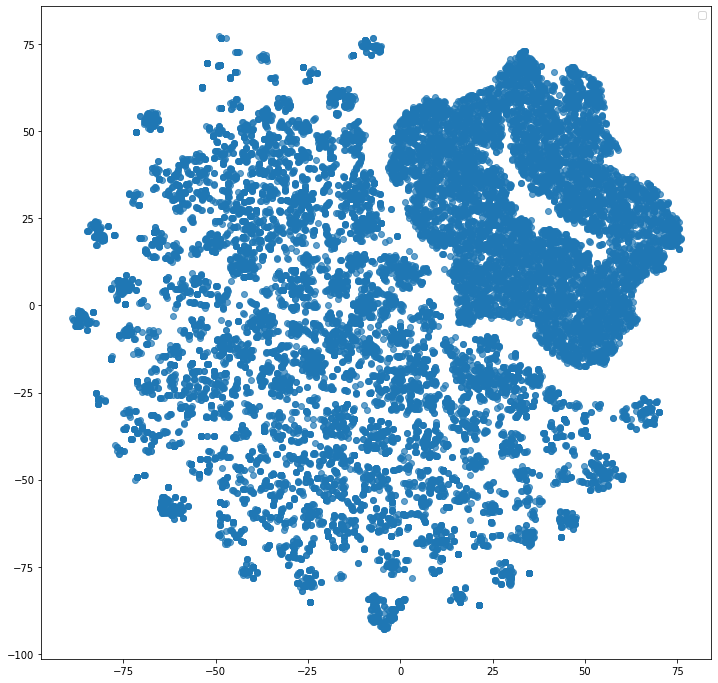

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 12))
plt.scatter(new_arr[:, 0], new_arr[:, 1], alpha = 0.7) 
plt.legend()
plt.show()

In [41]:
import json

with open('/opt/ml/level-3-final-project/Model-Server/preprocessing/problem_id2idx.json', 'r', encoding = 'utf-8') as f:
    problem_id2idx = json.load(f)

with open('/opt/ml/level-3-final-project/Model-Server/preprocessing/idx2problem_id.json', 'r', encoding = 'utf-8') as f:
    idx2problem_id = json.load(f)

In [42]:
from gensim.models import Word2Vec

model = Word2Vec.load(os.path.join(MODEL_PATH, 'Word2Vec_problem_seq.model'))

In [43]:
Problem_list = model.wv.key_to_index.keys()

arr = []

for idx in range(len(Problem_list)):
    arr.append(model.wv[idx2problem_id[str(idx)]])

arr = np.array(arr)

In [45]:
from sklearn.metrics.pairwise import cosine_similarity

cos_arr = cosine_similarity(arr, arr)